In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import maxabs_scale
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.model_selection import train_test_split

%matplotlib inline

# Data

Gathering and preparation of the data to be inputed into the model.

The countries were selected in the EDA file, populations were taken from https://worldpopulationreview.com/countries.

In [2]:
# Spain, UK, Italy, Germany...
# cc_dict = {
#     'ARG': 'Argentina', 'AUS': 'Australia',  
#     'CHN': 'China',     'CZE': 'Czechia',    
#     'EGY': 'Egypt',     'FIN': 'Finland',
#     'HND': 'Honduras',  'IND': 'India',
#     'JPN': 'Japan',     'NOR': 'Norway',
#     'RUS': 'Russia',    'SWE': 'Sweden',
#     'THA': 'Thailand',  'USA': 'US'
# }

cc_dict = {
    'BEL': 'Belgium',      'CMR': 'Cameroon',    'DOM': 'Dominican Republic',
    'EGY': 'Egypt',        'IRQ': 'Iraq',        'JOR': 'Jordan',
    'MLI': 'Mali',         'MWI': 'Malawi',      'NLD': 'Netherlands',
    'POL': 'Poland',       'SSD': 'South Sudan', 'TUN': 'Tunisia',
    'ZAF': 'South Africa', 'ZMB': 'Zambia',      'ZWE': 'Zimbabwe'
}

# pop_dict = { # 2020 population
#     'ARG': 45195774,   'AUS': 25499884, 
#     'CHN': 1439323776, 'CZE': 10708981,   
#     'EGY': 102334404,  'FIN': 5540720,  
#     'HND': 9904607,    'IND': 1380004385, 
#     'JPN': 126476461,  'NOR': 5421241,  
#     'RUS': 145934462,  'SWE': 10099265,
#     'THA': 69799978,   'USA': 331002651
# }

pop_dict = {
    'BEL': 11589623,  'CMR': 26545863, 'DOM': 10847910,
    'EGY': 102334404, 'IRQ': 40222493, 'JOR': 10203134,
    'MLI': 20250833,  'MWI': 19129952, 'NLD': 17134872,
    'POL': 37846611,  'SSD': 11193725, 'TUN': 11818619,
    'ZAF': 59308690,  'ZMB': 18383955, 'ZWE': 14862924
}

# pd.read_html('https://worldpopulationreview.com/countries', header=0, index_col=1)[0].reindex(cc_dict.values())

## Virus

Virus propagation data is obtained from the CSSE at Johns Hopkins University.

In [3]:
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recov = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [4]:
jhu_cases = pd.read_csv(url_cases)
jhu_cases.shape

(279, 569)

In [5]:
jhu_death = pd.read_csv(url_death)
jhu_death.shape

(279, 569)

In [6]:
jhu_recov = pd.read_csv(url_recov)
jhu_recov.shape

(264, 569)

Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level.

This is shown for the `cases` data set, but it happens in the three of them.

In [7]:
jhu_cases[jhu_cases['Country/Region'] == 'Australia']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/30/21,7/1/21,7/2/21,7/3/21,7/4/21,7/5/21,7/6/21,7/7/21,7/8/21,7/9/21,7/10/21,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21,7/21/21,7/22/21,7/23/21,7/24/21,7/25/21,7/26/21,7/27/21,7/28/21,7/29/21,7/30/21,7/31/21,8/1/21,8/2/21,8/3/21,8/4/21,8/5/21,8/6/21,8/7/21,8/8/21
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,5854,5886,5926,5942,5979,5997,6025,6064,6109,6161,6243,6359,6452,6551,6618,6716,6833,6942,7042,7121,7233,7357,7492,7651,7792,7943,8118,8294,8531,8703,8915,9153,9360,9562,9795,10063,10354,10662,10917,11201
10,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,185,185,185,185,185,185,185,185,186,188,188,188,189,189,189,190,191,191,191,191,191,191,191,191,192,192,192,192,197,197,197,199,200,200,198,198,198,199,199,199
11,Queensland,Australia,-27.4698,153.0251,0,0,0,0,0,0,0,1,3,2,3,2,2,3,3,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,...,1700,1705,1714,1715,1723,1728,1729,1732,1732,1737,1738,1739,1742,1747,1752,1753,1754,1755,1757,1761,1761,1761,1764,1763,1770,1771,1770,1790,1791,1793,1800,1809,1824,1840,1859,1886,1896,1909,1918,1923
12,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,807,807,809,810,813,813,813,813,814,816,818,819,821,821,823,825,831,831,832,838,840,846,850,851,855,856,856,857,859,859,859,859,862,863,866,866,866,866,866,868
13,Tasmania,Australia,-42.8821,147.3272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,235,235,235,235,235
14,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,20712,20715,20713,20714,20716,20718,20718,20718,20719,20722,20722,20722,20725,20727,20737,20748,20767,20785,20799,20813,20837,20865,20879,20891,20903,20914,20924,20932,20939,20942,20944,20948,20950,20955,20955,20961,20967,20997,21010,21021
15,Western Australia,Australia,-31.9505,115.8605,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1027,1028,1029,1029,1030,1032,1033,1033,1033,1033,1033,1036,1036,1036,1036,1036,1037,1037,1037,1038,1046,1048,1048,1048,1048,1048,1048,1050,1051,1057,1057,1057,1058,1058,1058,1058,1058,1059,1059,1059


In [8]:
jhu_cases[jhu_cases['Country/Region'] == 'Netherlands']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/30/21,7/1/21,7/2/21,7/3/21,7/4/21,7/5/21,7/6/21,7/7/21,7/8/21,7/9/21,7/10/21,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21,7/21/21,7/22/21,7/23/21,7/24/21,7/25/21,7/26/21,7/27/21,7/28/21,7/29/21,7/30/21,7/31/21,8/1/21,8/2/21,8/3/21,8/4/21,8/5/21,8/6/21,8/7/21,8/8/21
193,Aruba,Netherlands,12.5211,-69.9683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11138,11140,11144,11144,11144,11144,11144,11144,11144,11169,11169,11169,11169,11180,11186,11199,11199,11223,11235,11244,11257,11272,11293,11325,11354,11382,11405,11460,11521,11584,11651,11730,11765,11807,11877,12000,12000,12262,12371,12455
194,"Bonaire, Sint Eustatius and Saba",Netherlands,12.1784,-68.2385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1649,1650,1651,1651,1651,1652,1652,1652,1654,1656,1658,1659,1660,1661,1661,1661,1664,1668,1672,1672,1683,1683,1690,1691,1692,1693,1693,1697,1703,1705,1707,1707,1710,1710,1710,1710,1713,1715,1720,1724
195,Curacao,Netherlands,12.1696,-68.9900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12342,12343,12345,12349,12349,12349,12350,12354,12364,12371,12380,12389,12395,12418,12453,12537,12605,12699,12775,12804,12883,12962,13038,13135,13217,13252,13300,13378,13447,13493,13567,13625,13669,13692,13757,13835,13907,13988,14055,14122
196,Sint Maarten,Netherlands,18.0425,-63.0548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2618,2618,2618,2620,2620,2627,2630,2632,2633,2633,2638,2638,2641,2650,2656,2659,2659,2664,2664,2677,2687,2695,2698,2698,2707,2707,2723,2729,2743,2760,2770,2770,2770,2770,2824,2848,2891,2924,2950,2950
197,NaN,Netherlands,52.1326,5.2913,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1685000,1685825,1686766,1687891,1689106,1690625,1692834,1696480,1701911,1708837,1719120,1728438,1736879,1744700,1755126,1766102,1777399,1788435,1798570,1807444,1814143,1821040,1827273,1833668,1838937,1843521,1847372,1851329,1854784,1859199,1862586,1865511,1867815,1869909,1872093,1874856,1878214,1881121,1883513,1885805


Canada does not have recovery data available at province-level.

In [9]:
jhu_cases['Country/Region'].value_counts().head(9)

China             34
Canada            16
France            12
United Kingdom    12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Mozambique         1
Name: Country/Region, dtype: int64

In [10]:
jhu_death['Country/Region'].value_counts().head(9)

China             34
Canada            16
France            12
United Kingdom    12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Mozambique         1
Name: Country/Region, dtype: int64

In [11]:
jhu_recov['Country/Region'].value_counts().head(9)

China             34
France            12
United Kingdom    12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Vanuatu            1
Mauritius          1
Name: Country/Region, dtype: int64

Remove global registries from countries with subregional registies and the sum up these subregional cases.

In [12]:
sel_reg = ['Netherlands', 'United Kingdom', 'France', 'Denmark']

def remove_global_registry(jhu_df):
  'Remove global country records when local ones exist.'
  a = jhu_df['Country/Region'].isin(sel_reg)
  b = jhu_df['Province/State'].isna()
  cond = pd.DataFrame([a, b]).all()
  idx = jhu_df[cond].index
  jhu_df.drop(idx, axis=0, inplace=True)

# remove global Netherlands, UK, France and Denmark
remove_global_registry(jhu_cases)
remove_global_registry(jhu_death)
remove_global_registry(jhu_recov)
# drop subregion, latitude and longitude columns
jhu_cases.drop(jhu_cases.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_death.drop(jhu_death.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_recov.drop(jhu_recov.columns[[0, 2, 3]], axis=1, inplace=True)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (275, 566)
deaths shape: (275, 566)
recoveries shape: (260, 566)


In [13]:
# reshape dfs
jhu_cases = jhu_cases.groupby('Country/Region').sum()
jhu_cases = jhu_cases.T # transpose columns / rows
jhu_cases.index = pd.to_datetime(jhu_cases.index)
jhu_death = jhu_death.groupby('Country/Region').sum()
jhu_death = jhu_death.T # transpose columns / rows
jhu_death.index = pd.to_datetime(jhu_death.index)
jhu_recov = jhu_recov.groupby('Country/Region').sum()
jhu_recov = jhu_recov.T # transpose columns / rows
jhu_recov.index = pd.to_datetime(jhu_recov.index)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (565, 195)
deaths shape: (565, 195)
recoveries shape: (565, 195)


Create separate dataframes containing data on countries of interest only. Apply a smoothing average to the curves. Use them to compute further variables needed for the model.

In [14]:
window = 5

In [15]:
cum_cases = jhu_cases[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_cases

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0.00,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.000000
2020-01-23,0.00,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.000000
2020-01-24,0.00,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.000000
2020-01-25,0.00,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.000000
2020-01-26,0.00,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,1132868.60,82064.0,343207.400000,284470.400000,1.672705e+06,774199.400000,14607.400000,54120.200000,30388.000000,2.883454e+06,11082.0,600853.8,2.485069e+06,197798.800000,113350.000000
2021-08-05,1134410.20,82064.0,343505.600000,284526.200000,1.683833e+06,775084.400000,14617.000000,54662.600000,30611.400000,2.883626e+06,11089.4,603121.6,2.497415e+06,198433.200000,114357.000000
2021-08-06,1135603.80,82064.0,343834.600000,284584.400000,1.694300e+06,775785.800000,14626.400000,55146.000000,30828.000000,2.883788e+06,11094.2,605898.6,2.509959e+06,199018.400000,115135.400000
2021-08-07,1136271.25,82064.0,343996.750000,284612.500000,1.699604e+06,776093.750000,14631.750000,55388.000000,30936.750000,2.883874e+06,11097.5,606684.0,2.516447e+06,199325.250000,115537.750000


In [16]:
cum_deaths = jhu_death[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_deaths

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
2020-01-23,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
2020-01-24,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
2020-01-25,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
2020-01-26,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,25257.6,1334.0,3969.200000,16548.800000,18938.400000,10081.2,534.0,1727.60,291.000000,75270.200000,119.8,20446.200000,73413.80,3434.000000,3716.200000
2021-08-05,25261.8,1334.0,3971.400000,16555.000000,19007.200000,10094.8,534.0,1751.60,291.800000,75275.000000,120.0,20562.800000,73851.00,3446.400000,3754.400000
2021-08-06,25265.2,1334.0,3972.600000,16562.000000,19074.800000,10106.0,534.0,1777.20,292.800000,75279.000000,120.0,20703.800000,74215.20,3458.800000,3799.200000
2021-08-07,25267.0,1334.0,3973.000000,16565.000000,19109.000000,10112.0,534.0,1789.25,293.000000,75281.500000,120.0,20742.250000,74415.25,3466.000000,3821.250000


In [17]:
cum_recoveries = jhu_recov[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_recoveries

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,0.0,21156.6,194713.6,139099.6,892754.6,451230.0,8376.0,23463.0,17172.2,1592363.0,6308.4,314643.0,1349539.8,113589.8,48796.8
2021-08-05,0.0,14104.4,129868.2,92847.8,596589.2,300994.6,5584.4,15777.6,11473.0,1061583.0,4205.6,210376.0,901862.2,75799.8,32912.8
2021-08-06,0.0,7052.2,64972.2,46435.8,298952.0,150524.8,2792.4,7968.2,5754.2,530796.2,2102.8,106109.0,451720.6,37931.6,16598.8
2021-08-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
print('Total number of missing values in')
print(' - cases:', cum_cases.isna().sum().sum())
print(' - deaths:', cum_deaths.isna().sum().sum())
print(' - recoveries:', cum_recoveries.isna().sum().sum())

Total number of missing values in
 - cases: 0
 - deaths: 0
 - recoveries: 0


In [19]:
R = cum_deaths + cum_recoveries
R

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000e+00,0.0,0.000000,0.00,0.000000,0.000000
2020-01-23,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000e+00,0.0,0.000000,0.00,0.000000,0.000000
2020-01-24,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000e+00,0.0,0.000000,0.00,0.000000,0.000000
2020-01-25,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000e+00,0.0,0.000000,0.00,0.000000,0.000000
2020-01-26,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000e+00,0.0,0.000000,0.00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,25257.6,22490.6,198682.800000,155648.400000,911693.000000,461311.2,8910.0,25190.60,17463.200000,1.667633e+06,6428.2,335089.200000,1422953.60,117023.800000,52513.000000
2021-08-05,25261.8,15438.4,133839.600000,109402.800000,615596.400000,311089.4,6118.4,17529.20,11764.800000,1.136858e+06,4325.6,230938.800000,975713.20,79246.200000,36667.200000
2021-08-06,25265.2,8386.2,68944.800000,62997.800000,318026.800000,160630.8,3326.4,9745.40,6047.000000,6.060752e+05,2222.8,126812.800000,525935.80,41390.400000,20398.000000
2021-08-07,25267.0,1334.0,3973.000000,16565.000000,19109.000000,10112.0,534.0,1789.25,293.000000,7.528150e+04,120.0,20742.250000,74415.25,3466.000000,3821.250000


In [20]:
I = cum_cases - R
I

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000e+00,0.00,0.000000
2020-01-23,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000e+00,0.00,0.000000
2020-01-24,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000e+00,0.00,0.000000
2020-01-25,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000e+00,0.00,0.000000
2020-01-26,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000e+00,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,1107611.00,59573.4,144524.600000,128822.000000,761012.40,312888.200000,5697.400000,28929.600000,12924.800000,1215821.2,4653.8,265764.600000,1.062116e+06,80775.00,60837.000000
2021-08-05,1109148.40,66625.6,209666.000000,175123.400000,1068236.20,463995.000000,8498.600000,37133.400000,18846.600000,1746767.6,6763.8,372182.800000,1.521702e+06,119187.00,77689.800000
2021-08-06,1110338.60,73677.8,274889.800000,221586.600000,1376273.40,615155.000000,11300.000000,45400.600000,24781.000000,2277713.2,8871.4,479085.800000,1.984023e+06,157628.00,94737.400000
2021-08-07,1111004.25,80730.0,340023.750000,268047.500000,1680495.25,765981.750000,14097.750000,53598.750000,30643.750000,2808592.0,10977.5,585941.750000,2.442032e+06,195859.25,111716.500000


In [21]:
S = pop_dict.values() - cum_cases
S

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,11589623.00,26545863.0,1.084791e+07,1.023344e+08,4.022249e+07,1.020313e+07,2.025083e+07,1.912995e+07,1.713487e+07,3.784661e+07,11193725.0,11818619.0,5.930869e+07,1.838396e+07,1.486292e+07
2020-01-23,11589623.00,26545863.0,1.084791e+07,1.023344e+08,4.022249e+07,1.020313e+07,2.025083e+07,1.912995e+07,1.713487e+07,3.784661e+07,11193725.0,11818619.0,5.930869e+07,1.838396e+07,1.486292e+07
2020-01-24,11589623.00,26545863.0,1.084791e+07,1.023344e+08,4.022249e+07,1.020313e+07,2.025083e+07,1.912995e+07,1.713487e+07,3.784661e+07,11193725.0,11818619.0,5.930869e+07,1.838396e+07,1.486292e+07
2020-01-25,11589623.00,26545863.0,1.084791e+07,1.023344e+08,4.022249e+07,1.020313e+07,2.025083e+07,1.912995e+07,1.713487e+07,3.784661e+07,11193725.0,11818619.0,5.930869e+07,1.838396e+07,1.486292e+07
2020-01-26,11589623.00,26545863.0,1.084791e+07,1.023344e+08,4.022249e+07,1.020313e+07,2.025083e+07,1.912995e+07,1.713487e+07,3.784661e+07,11193725.0,11818619.0,5.930869e+07,1.838396e+07,1.486292e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,10456754.40,26463799.0,1.050470e+07,1.020499e+08,3.854979e+07,9.428935e+06,2.023623e+07,1.907583e+07,1.710448e+07,3.496316e+07,11182643.0,11217765.2,5.682362e+07,1.818616e+07,1.474957e+07
2021-08-05,10455212.80,26463799.0,1.050440e+07,1.020499e+08,3.853866e+07,9.428050e+06,2.023622e+07,1.907529e+07,1.710426e+07,3.496299e+07,11182635.6,11215497.4,5.681127e+07,1.818552e+07,1.474857e+07
2021-08-06,10454019.20,26463799.0,1.050408e+07,1.020498e+08,3.852819e+07,9.427348e+06,2.023621e+07,1.907481e+07,1.710404e+07,3.496282e+07,11182630.8,11212720.4,5.679873e+07,1.818494e+07,1.474779e+07
2021-08-07,10453351.75,26463799.0,1.050391e+07,1.020498e+08,3.852289e+07,9.427040e+06,2.023620e+07,1.907456e+07,1.710394e+07,3.496274e+07,11182627.5,11211935.0,5.679224e+07,1.818463e+07,1.474739e+07


### Initial approximation

Operate with the proportional compartments; $s, i, r$. Analyse the beginning of the pandemic, assuming $\lim_{t\rightarrow0}s\rightarrow1$. Therefore, study the change of the growth rate $g^*=\log{i_2}-\log{i_1}=\beta^*-\gamma^*$.

In [22]:
i_prop = I / pop_dict.values()
i_prop

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,0.095569,0.002244,0.013323,0.001259,0.018920,0.030666,0.000281,0.001512,0.000754,0.032125,0.000416,0.022487,0.017908,0.004394,0.004093
2021-08-05,0.095702,0.002510,0.019328,0.001711,0.026558,0.045476,0.000420,0.001941,0.001100,0.046154,0.000604,0.031491,0.025657,0.006483,0.005227
2021-08-06,0.095805,0.002775,0.025340,0.002165,0.034217,0.060291,0.000558,0.002373,0.001446,0.060183,0.000793,0.040537,0.033452,0.008574,0.006374
2021-08-07,0.095862,0.003041,0.031345,0.002619,0.041780,0.075073,0.000696,0.002802,0.001788,0.074210,0.000981,0.049578,0.041175,0.010654,0.007516


In [23]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i = np.log(i_prop)
warnings.resetwarnings()
# before the pandemic begins, the growth must be zero
log_i[np.isinf(log_i)] = 0
log_i

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,-2.347905,-6.099420,-4.318278,-6.677570,-3.967532,-3.484604,-8.175941,-6.494145,-7.189723,-3.438122,-7.785425,-3.794820,-4.022493,-5.427566,-5.498427
2021-08-05,-2.346518,-5.987540,-3.946212,-6.370510,-3.628417,-3.090576,-7.776050,-6.244494,-6.812538,-3.075774,-7.411524,-3.458046,-3.662926,-5.038540,-5.253901
2021-08-06,-2.345445,-5.886928,-3.675357,-6.135188,-3.375047,-2.808576,-7.491148,-6.043485,-6.538794,-2.810369,-7.140276,-3.205552,-3.397629,-4.758996,-5.055516
2021-08-07,-2.344846,-5.795519,-3.462712,-5.944837,-3.175338,-2.589292,-7.269936,-5.877485,-6.326442,-2.600858,-6.927261,-3.004211,-3.189926,-4.541837,-4.890661


In [24]:
gr = log_i[1:] - log_i[:-1].values # different index
gr

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,0.002166,0.125992,0.598017,0.443996,0.515265,0.659124,0.675713,0.329633,0.606858,0.573887,0.605126,0.503780,0.562170,0.639907,0.315666
2021-08-05,0.001387,0.111880,0.372066,0.307059,0.339115,0.394028,0.399892,0.249652,0.377185,0.362347,0.373901,0.336774,0.359567,0.389026,0.244526
2021-08-06,0.001073,0.100613,0.270855,0.235323,0.253371,0.282000,0.284901,0.201008,0.273745,0.265405,0.271248,0.252495,0.265297,0.279544,0.198385
2021-08-07,0.000599,0.091409,0.212645,0.190351,0.199709,0.219284,0.221212,0.166000,0.212351,0.209511,0.213015,0.201341,0.207703,0.217158,0.164856


### Transmission coefficient computation

Operate with the absolute compartments; $S, I, R$. This is, with the number of people in each compartment. Only assuming independence with time (same as last time), study $\beta=\frac{g+\gamma}{S}$.

Because the SIR model (instead of the SEIR model) is being used, the resulting transmission coefficient will be small.

In [25]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_I = np.log(I)
warnings.resetwarnings()
# before the pandemic begins
log_I[np.isinf(log_I)] = 0
log_I

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,13.917716,10.994964,11.881205,11.766187,13.542405,12.653601,8.647765,10.272621,9.466903,14.010930,8.445439,12.490366,13.875773,11.299423,11.015953
2021-08-05,13.919103,11.106844,12.253271,12.073246,13.881519,13.047629,9.047657,10.522272,9.844088,14.373278,8.819340,12.827140,14.235340,11.688449,11.260479
2021-08-06,13.920176,11.207457,12.524126,12.308569,14.134890,13.329630,9.332558,10.723281,10.117833,14.638683,9.090588,13.079635,14.500637,11.967993,11.458864
2021-08-07,13.920775,11.298866,12.736771,12.498919,14.334599,13.548914,9.553770,10.889281,10.330184,14.848194,9.303603,13.280976,14.708341,12.185152,11.623720


In [26]:
log_diff = log_I[1:] - log_I[:-1].values # different index
log_diff

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,0.002166,0.125992,0.598017,0.443996,0.515265,0.659124,0.675713,0.329633,0.606858,0.573887,0.605126,0.503780,0.562170,0.639907,0.315666
2021-08-05,0.001387,0.111880,0.372066,0.307059,0.339115,0.394028,0.399892,0.249652,0.377185,0.362347,0.373901,0.336774,0.359567,0.389026,0.244526
2021-08-06,0.001073,0.100613,0.270855,0.235323,0.253371,0.282000,0.284901,0.201008,0.273745,0.265405,0.271248,0.252495,0.265297,0.279544,0.198385
2021-08-07,0.000599,0.091409,0.212645,0.190351,0.199709,0.219284,0.221212,0.166000,0.212351,0.209511,0.213015,0.201341,0.207703,0.217158,0.164856


In [27]:
dR_dt = R[1:] - R[:-1].values # different index
dR_dt

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-23,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
2020-01-24,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
2020-01-25,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
2020-01-26,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
2020-01-27,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,5.4,-7052.2,-64738.000000,-46133.000000,-294348.000000,-150224.0,-2789.4,-7606.40,-5685.000000,-530757.400000,-2102.6,-103243.800000,-445742.00,-37610.600000,-15288.600000
2021-08-05,4.2,-7052.2,-64843.200000,-46245.600000,-296096.600000,-150221.8,-2791.6,-7661.40,-5698.400000,-530775.200000,-2102.6,-104150.400000,-447240.40,-37777.600000,-15845.800000
2021-08-06,3.4,-7052.2,-64894.800000,-46405.000000,-297569.600000,-150458.6,-2792.0,-7783.80,-5717.800000,-530782.800000,-2102.8,-104126.000000,-449777.40,-37855.800000,-16269.200000
2021-08-07,1.8,-7052.2,-64971.800000,-46432.800000,-298917.800000,-150518.8,-2792.4,-7956.15,-5754.000000,-530793.700000,-2102.8,-106070.550000,-451520.55,-37924.400000,-16576.750000


In [28]:
# to do: decide on infinite values
gamma = dR_dt / I[1:]
gamma[np.isinf(gamma)] = np.nan # division by zero
gamma[gamma.isna()] = 0         # before the pandemic begins
gamma

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-27,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,4.875358e-06,-0.118378,-0.447938,-0.358114,-0.386785,-0.480120,-0.489592,-0.262928,-0.439852,-4.365423e-01,-0.451803,-0.388478,-0.419674,-0.465622,-0.251304
2021-08-05,3.786689e-06,-0.105848,-0.309269,-0.264074,-0.277183,-0.323757,-0.328478,-0.206321,-0.302357,-3.038614e-01,-0.310861,-0.279837,-0.293908,-0.316961,-0.203962
2021-08-06,3.062129e-06,-0.095717,-0.236076,-0.209422,-0.216214,-0.244586,-0.247080,-0.171447,-0.230733,-2.330332e-01,-0.237031,-0.217343,-0.226700,-0.240159,-0.171729
2021-08-07,1.620156e-06,-0.087355,-0.191080,-0.173226,-0.177875,-0.196504,-0.198074,-0.148439,-0.187771,-1.889893e-01,-0.191555,-0.181026,-0.184895,-0.193631,-0.148382


In [29]:
beta = (log_diff + gamma) / S[1:]
beta

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-24,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-26,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-04,2.076320e-10,2.877112e-10,1.428691e-08,8.415642e-10,3.332832e-09,1.898451e-08,9.197433e-09,3.496863e-09,9.763880e-09,3.928269e-09,1.371085e-08,1.027849e-08,2.507699e-09,9.583409e-09,4.363641e-09
2021-08-05,1.330300e-10,2.279159e-10,5.978161e-09,4.212146e-10,1.607004e-09,7.453341e-09,3.529014e-09,2.271554e-09,4.374796e-09,1.672794e-09,5.637313e-09,5.076680e-09,1.155733e-09,3.962792e-09,2.750328e-09
2021-08-06,1.028851e-10,1.850032e-10,3.310982e-09,2.538085e-10,9.643981e-10,3.968667e-09,1.869008e-09,1.549762e-09,2.514697e-09,9.258910e-10,3.059781e-09,3.134963e-09,6.795524e-10,2.165805e-09,1.807420e-09
2021-08-07,5.748800e-11,1.531654e-10,2.053044e-09,1.678074e-10,5.667878e-10,2.416416e-09,1.143412e-09,9.206674e-10,1.437140e-09,5.869701e-10,1.919017e-09,1.811901e-09,4.016043e-10,1.293817e-09,1.117030e-09


## Policy

We focus on policies aimed at obstructing the spread of the virus. The Oxford group considers four types of measures:

*   Containment
*   Economic
*   Health system
*   Miscellaneous

Here containment- and some health system-related measures are considered.

In [30]:
url_pol = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'

oxcgrt = pd.read_csv(url_pol, dtype={'RegionName': str, 'RegionCode': str})

oxcgrt.drop(oxcgrt.columns[37:], axis=1, inplace=True)    # indexes and extra

oxcgrt['Date'] = pd.to_datetime(oxcgrt['Date'], format='%Y%m%d')
oxcgrt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183144 entries, 0 to 183143
Data columns (total 37 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   CountryName                            183144 non-null  object        
 1   CountryCode                            183144 non-null  object        
 2   RegionName                             73962 non-null   object        
 3   RegionCode                             73962 non-null   object        
 4   Jurisdiction                           183144 non-null  object        
 5   Date                                   183144 non-null  datetime64[ns]
 6   C1_School closing                      177239 non-null  float64       
 7   C1_Flag                                145356 non-null  float64       
 8   C2_Workplace closing                   177162 non-null  float64       
 9   C2_Flag                                137811 no

Policy implementation is available at state level in some countries.

In [31]:
oxcgrt_sub = oxcgrt[oxcgrt['Jurisdiction'] == 'STATE_TOTAL'].copy()
oxcgrt_sub

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people
13501,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
13502,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
13503,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
13504,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
13505,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177856,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177857,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177858,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177859,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-08-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# region information
oxcgrt.drop(oxcgrt.columns[[2, 3]], axis=1, inplace=True)

oxcgrt = oxcgrt[oxcgrt['Jurisdiction'] == 'NAT_TOTAL']
oxcgrt

,CountryName,CountryCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people
0,Aruba,ABW,NAT_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
1,Aruba,ABW,NAT_TOTAL,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
2,Aruba,ABW,NAT_TOTAL,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
3,Aruba,ABW,NAT_TOTAL,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
4,Aruba,ABW,NAT_TOTAL,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183139,Zimbabwe,ZWE,NAT_TOTAL,2021-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183140,Zimbabwe,ZWE,NAT_TOTAL,2021-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183141,Zimbabwe,ZWE,NAT_TOTAL,2021-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183142,Zimbabwe,ZWE,NAT_TOTAL,2021-08-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The Oxford dataset contains earlier dates compared to the JHU dataset.

In [33]:
print('Virus data: ', jhu_cases.index.min(), '-', jhu_cases.index.max())
print('Policy data:', oxcgrt['Date'].min(), '-', oxcgrt['Date'].max())

Virus data:  2020-01-22 00:00:00 - 2021-08-08 00:00:00
Policy data: 2020-01-01 00:00:00 - 2021-08-09 00:00:00


Pivot the data to obtain a different dataset for each policy type indexed by time (date).

In [34]:
idch = list(oxcgrt.columns[4:19:2])
idch.append(oxcgrt.columns[24])
idch.append(oxcgrt.columns[30])

C1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[0])
C2 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[1])
C3 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[2])
C4 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[3])
C5 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[4])
C6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[5])
C7 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[6])
C8 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[7])
H1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[8])
H6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[9])

CH_X = [C1, C2, C3, C4, C5, C6, C7, C8, H1, H6]
 
idch

['C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'H1_Public information campaigns',
 'H6_Facial Coverings']

Correlation of the different containment policy types. Can be used to supress highly correlated policies.

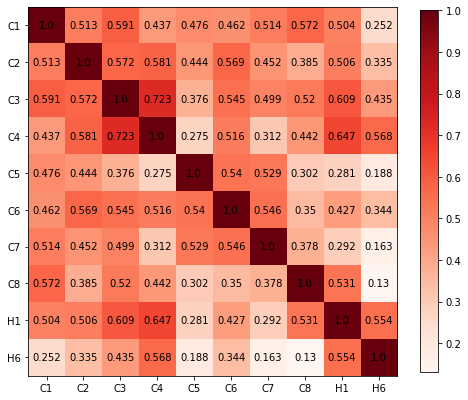

In [35]:
mask = oxcgrt['CountryCode'].isin(cc_dict)
corr = oxcgrt.loc[mask, idch].corr()

# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=corr, cmap='Reds') # 
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# show all ticks...
ax.set_xticks(range(corr.shape[1]))
ax.set_yticks(range(corr.shape[0]))
# ...and label them
[s.split('_')[0] for s in idch]
ax.set_xticklabels([s.split('_')[0] for s in corr.columns])
ax.set_yticklabels([s.split('_')[0] for s in corr.index])
# loop over data dimensions and create text annotations
for i in range(corr.shape[1]):
  for j in range(corr.shape[0]):
    text = ax.text(j, i, round(corr.iloc[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

In [36]:
print('Missing values per indicator:')
print(' - C1:', C1[cc_dict.keys()].isna().sum().sum())
print(' - C2:', C2[cc_dict.keys()].isna().sum().sum())
print(' - C3:', C3[cc_dict.keys()].isna().sum().sum())
print(' - C4:', C4[cc_dict.keys()].isna().sum().sum())
print(' - C5:', C5[cc_dict.keys()].isna().sum().sum())
print(' - C6:', C6[cc_dict.keys()].isna().sum().sum())
print(' - C7:', C7[cc_dict.keys()].isna().sum().sum())
print(' - C8:', C8[cc_dict.keys()].isna().sum().sum())
print(' - H1:', H1[cc_dict.keys()].isna().sum().sum())
print(' - H6:', H6[cc_dict.keys()].isna().sum().sum())

Missing values per indicator:
 - C1: 174
 - C2: 184
 - C3: 173
 - C4: 175
 - C5: 173
 - C6: 176
 - C7: 176
 - C8: 181
 - H1: 207
 - H6: 197


## Visualizations

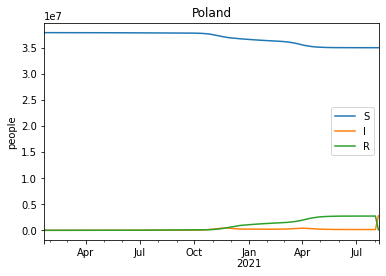

In [37]:
cc_idx = 9
country = list(cc_dict.values())[cc_idx]

S[country].plot()
I[country].plot()
R[country].plot()
plt.ylabel('people')
plt.title(country)
plt.legend(labels=['S', 'I', 'R'])
plt.show()

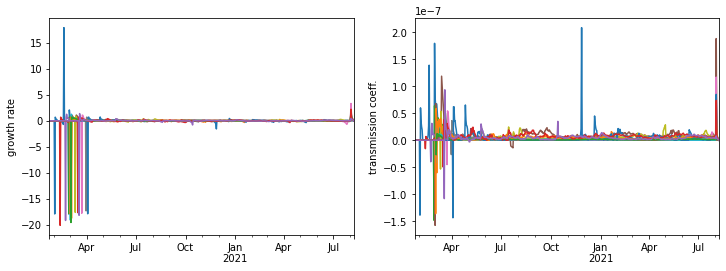

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
gr.plot(legend=False, ax=axs[0])
beta.plot(legend=False, ax=axs[1])
axs[0].set_ylabel('growth rate')
axs[1].set_ylabel('transmission coeff.')
plt.show()

Most countries present spikes at the beginning of the pandemic. Possibly due to reporting concentrations. Furthermore, low populated countries present various spikes.

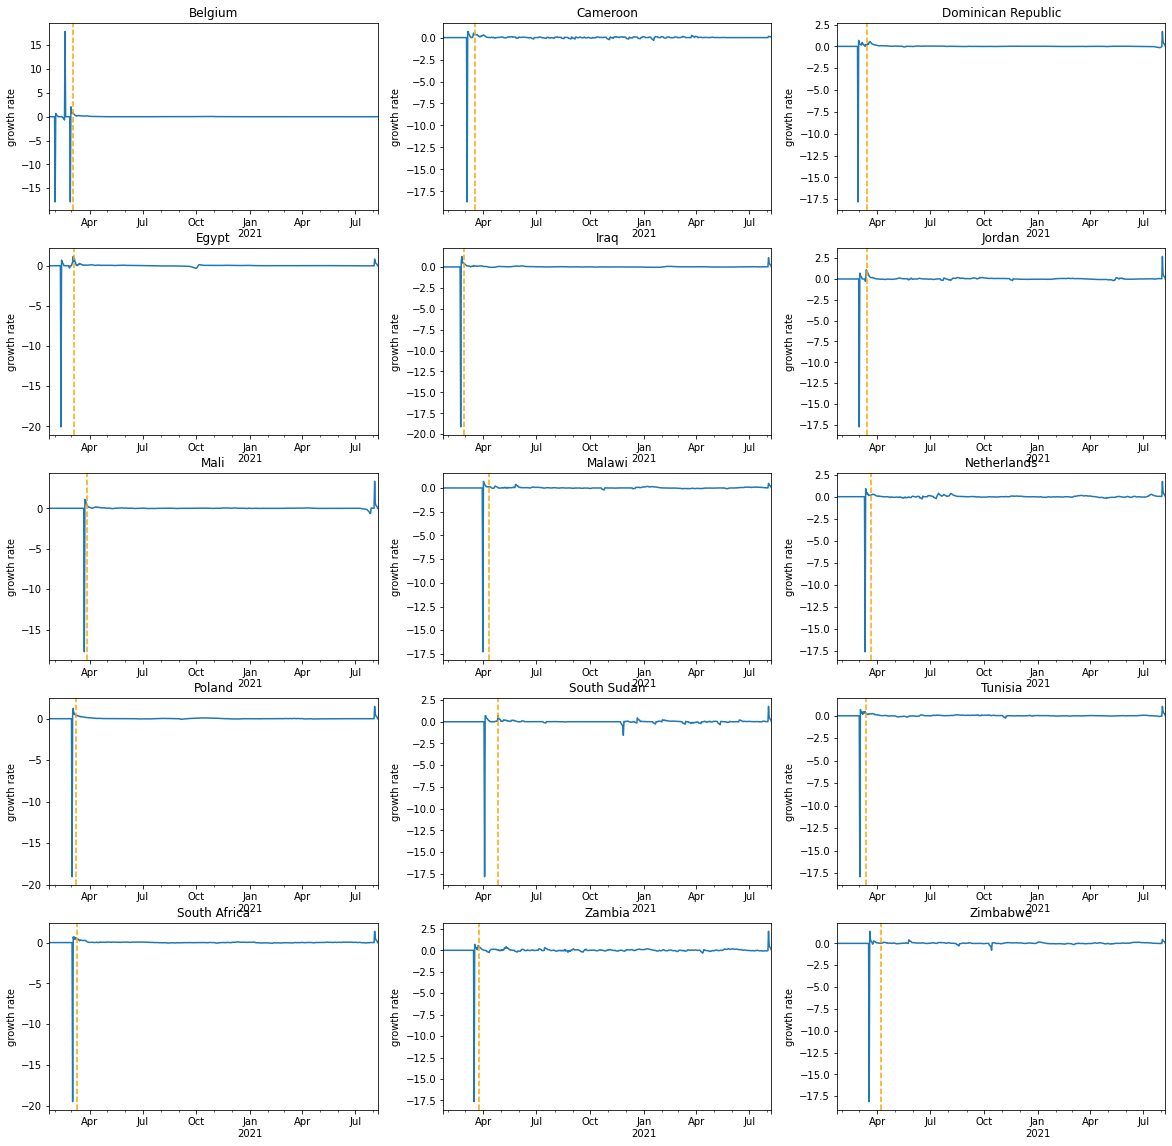

In [39]:
nrows = len(cc_dict) // 3
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname][cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  gr[cname].plot(ax=ax)
  ax.axvline(first, ls='--', color='orange')
  ax.set_title(cname)
  ax.set_ylabel('growth rate')

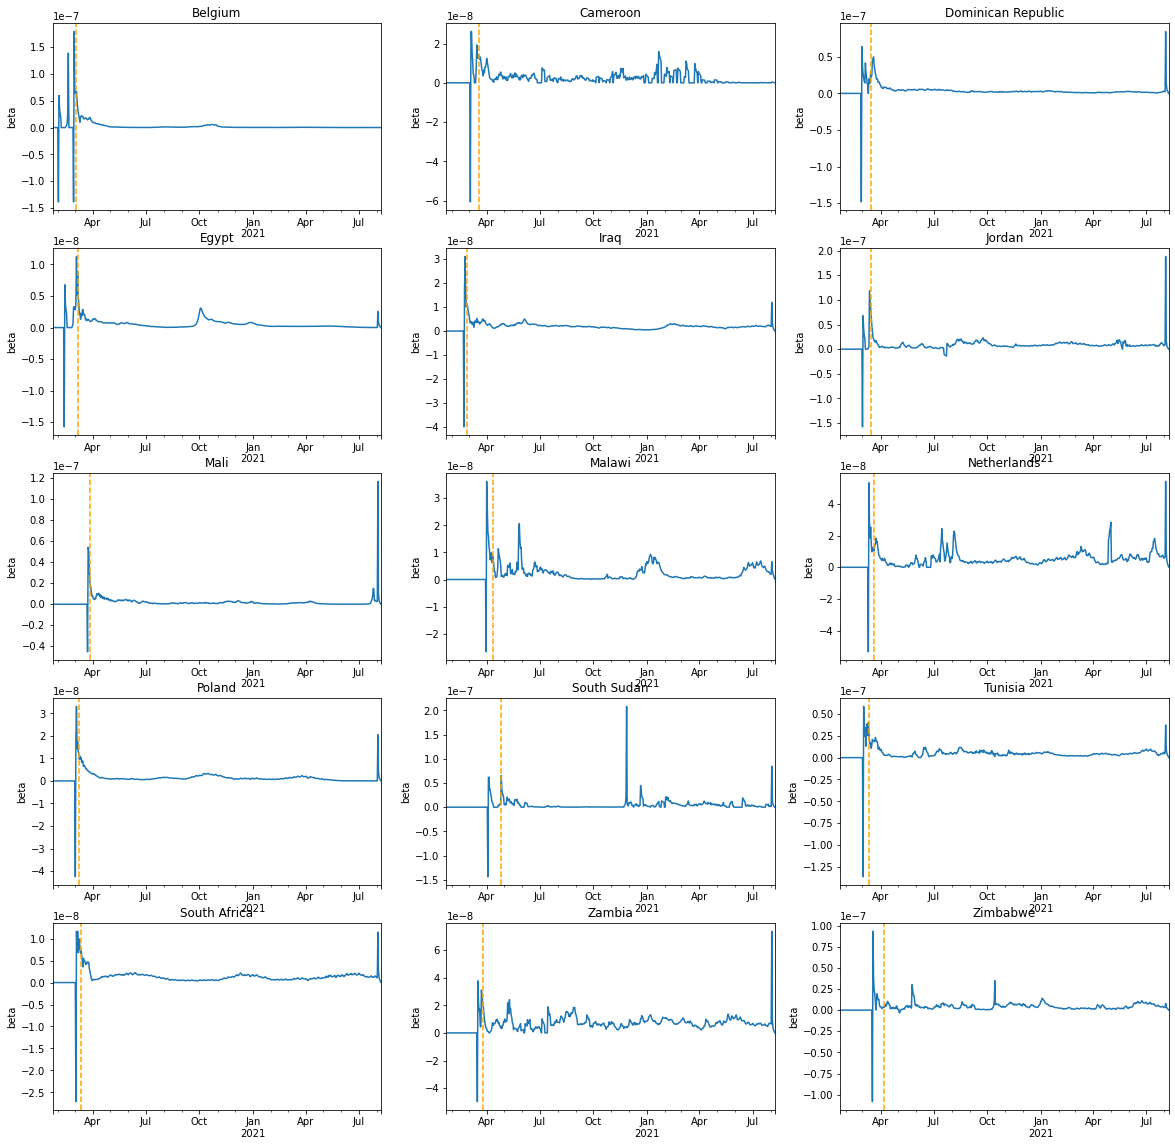

In [40]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname].loc[cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  beta[cname].plot(ax=ax)
  ax.axvline(first, ls='--', color='orange')
  ax.set_title(cname)
  ax.set_ylabel('beta')

# Model

Development of the model(s) and results.

## Auxiliar

In [41]:
# aux vars
ta = gr.index.min()
tb = gr.index.max()

chx_str = [s.split('_')[0] for s in idch]

In [42]:
ta == beta.index.min()

True

In [43]:
# to do: different fns for the two labels
# aux fns
def data_from(iso, t0, tr, t_d, y):
  'Select data with location and time constraints.'

  if iso in cc_dict.keys():
    name = cc_dict[iso]
  elif iso in tot_dict.keys():
    name = tot_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  if not t0:
    t0 = cum_cases.loc[cum_cases[name] > 25, name].index.min()
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  
  if not tr:
    t1 = tb
  else:
    prop_case = cum_cases[name] / pop_dict[iso]
    t1 = prop_case[prop_case < tr/100].index.max()
  
  delay = pd.to_timedelta(t_d, unit='days')
  ch_x = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_X]
  pol_t = pd.concat(ch_x, axis=1, ignore_index=True)
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

def preprocess(pol_t, y_t):
  'Transform data to feed the model.'
  
  pol_t.fillna(method='pad', inplace=True) # back fill
  pol_norm = maxabs_scale(pol_t[1:])       # match vars length at scaling
  y_norm = maxabs_scale(y_t)

  # day = y_t[1:].index.weekday.values.reshape(-1, 1)
  # ohe = OneHotEncoder(sparse=False).fit_transform(day)
  # ohe_str = [f'weekday {d+1}' for d in range(7)]
  td1 = y_norm[:-1].reshape(-1, 1)
  # group data
  arr = np.hstack([pol_norm, td1])
  col = chx_str + ['last']
  df = pd.DataFrame(arr, columns=col)
  
  return df, y_norm[1:]

def _print_model(name, value, score):
  print('Coefficients\n------------')
  for n, v in zip(name, value):
    if v != 0:
      print('{:s} : {:3f}'.format(n, v))
  print('\nR^2\n---')
  print(round(score, 3))

## Initial model

Customized grid of values for the parameters.

Compare the linear regression and Lasso stability of coefficients.

The code is:

```
cv_flag = True
y_df = gr_smooth
cv_arr = []
grid = {'tr': [0.5, 0.75, 1, 2, 3], 'delay': [7, 10, 14, 18, 21]}
lin = LinearRegression()
# lasso = LassoLarsCV(cv=KFold(shuffle=True), max_iter=3, eps=.1**7)
# lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**5)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    cv_par = []
    X_raw, y_raw = data_from(cc, t0=None, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw)
    if cv_flag:
      # cross-validation
      kf = KFold(shuffle=True)
      cv_kf = []
      for train_idx, test_idx in kf.split(X):
        fit = lin.fit(X.values[train_idx], y.values[train_idx])
        kf_score = fit.score(X.values[test_idx], y.values[test_idx])
        cv_kf.append(kf_score)
        score = np.asarray(cv_kf).mean()
    else:
      # train-test
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
      score = lin.fit(X_train, y_train).score(X_test, y_test)
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr
```

The LARS implementation of Lasso is much faster and it was used for the CV loop. However, the number of regressors needs to be restricted due to convergency issues and the general accuracy obtained is lower compared to the standard *brute force* Lasso. Therefore, the LARS implementation it is not used anymore.

Using cross-validation on all available data, can yield sizeable negative values (sometimes) while performing least squares. Filter those values or assign value zero.

In [44]:
y_df = gr
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, t0=None, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lin.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      # to do: filter negative values
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([-5.20865472e+25, -3.04562385e+24,  6.78474321e-01, -1.03964969e+25,
        5.93502171e-01,  6.02199461e-01, -5.62929767e+25, -3.17510298e+25,
       -1.48899415e+24,  6.09047730e-01,  5.83843293e-01, -1.37026960e+25,
        5.47745731e-01,  6.59926723e-01,  6.47676027e-01,  5.83041675e-01,
        6.00237468e-01,  5.84651226e-01, -1.06198102e+25,  6.37587611e-01,
        6.91548298e-01,  6.42416852e-01,  6.31666374e-01, -5.85459458e+24,
        5.74165978e-01])

In [45]:
cv_arr.mean()

-7.409550773683788e+24

In [ ]:
y_df = gr
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**4)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, t0=None, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.56031956, 0.6848395 , 0.68433686, 0.62976862, 0.61464746,
       0.61432403, 0.5958851 , 0.66517541, 0.68927062, 0.66184015,
       0.60659235, 0.67834949, 0.63896335, 0.6563123 , 0.64844043,
       0.65084628, 0.6051287 , 0.67864949, 0.70489164, 0.65298271,
       0.53572339, 0.61760078, 0.66891413, 0.68357515, 0.59104071])

In [ ]:
cv_arr.mean()

0.6407367273678717

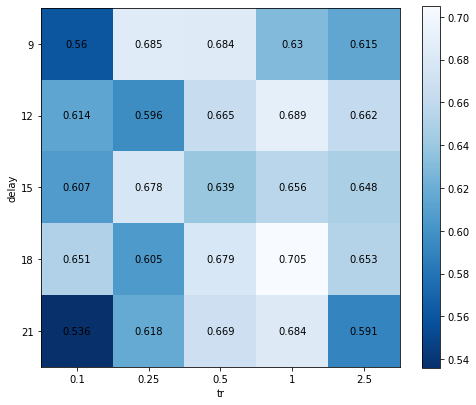

In [ ]:
cv_mat = cv_arr.reshape(5, 5)
# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=cv_mat, cmap='Blues_r') # 
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# axis titles
ax.set_xlabel('tr')
ax.set_ylabel('delay')
# show all ticks...
ax.set_xticks(np.arange(len(grid['tr'])))
ax.set_yticks(np.arange(len(grid['delay'])))
# ...and label them
ax.set_xticklabels(grid['tr'])
ax.set_yticklabels(grid['delay'])
# loop over data dimensions and create text annotations
for i in range(len(grid['tr'])):
  for j in range(len(grid['delay'])):
    text = ax.text(j, i, round(cv_mat[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

In [ ]:
def initial_model(region, tr=1, delay=12, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from(region, None, tr, delay, gr)
  X, y = preprocess(X_raw, y_raw)
  coef_names = X.columns.values

  lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**4)
  reg = lasso.fit(X, y)
  score = reg.score(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y

Performance ($R^2$) for the chosen parameteres. It is obtained from the training data.

In [ ]:
models = [initial_model(k) for k in cc_dict.keys()]
r_sq = [reg.score(X, y) for reg, X, y in models]
np.asarray(r_sq).mean()

0.7021849704388113

In [ ]:
for r_i in r_sq:
  print(round(r_i, 2))

0.97
0.62
0.97
0.65
0.89
0.84
0.1
0.73
0.45
0.98
0.25
0.88
0.93
0.72
0.56


Textual representation of the model.

In [ ]:
idx = 6 # country index
cci = list(cc_dict.keys())[idx]
initial_model(cci, print=True)

Coefficients
------------
C6 : 0.000702
H6 : -0.007201
last : 0.234733

R^2
---
0.096


In [ ]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


Visual representation of the model.

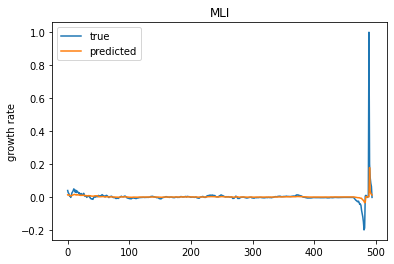

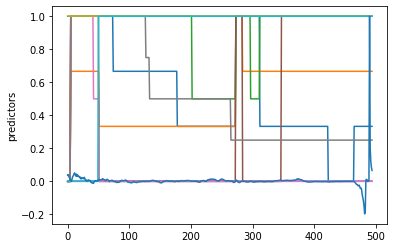


Number of data points: 495
Number of variables: 11


In [ ]:
model, X, y = initial_model(cci)

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()

print('\nNumber of data points:', X.shape[0])
print('Number of variables:', X.shape[1])

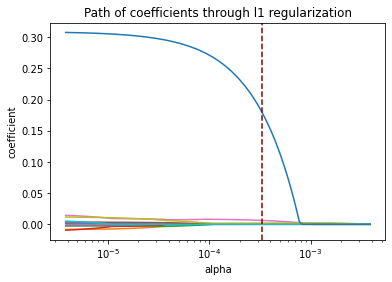

In [ ]:
alphas, coefs = model.path(X, y)[:2]
for coef in coefs:
  plt.semilogx(alphas, coef)
plt.axvline(model.alpha_, ls='--', color='darkred')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.title('Path of coefficients through l1 regularization')
plt.show()

Growth rate for every country of interest.

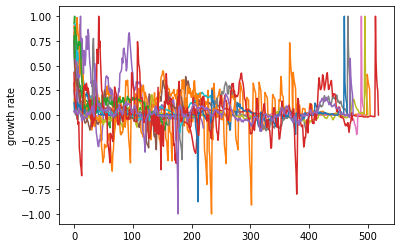

In [ ]:
for cc in cc_dict:
  model, X, y = initial_model(cc)
  plt.plot(y)
plt.ylabel('growth rate')
plt.show()

## Transmission analysis

Parameter grid search.

In [ ]:
y_df = beta
cv_arr = []
grid = range(7, 21) # delay
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t0=None, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lin.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([-2.83986615e-01,  1.63451548e-01, -3.34985933e-01, -1.97864915e-02,
       -8.44321295e-02, -1.25039787e-01, -3.39068754e-01, -1.19277971e-04,
       -1.40284164e-01, -6.96503448e-02,  1.15542572e-02,  1.95658395e-01,
        3.12567172e-02, -1.08892638e-01])

In [ ]:
cv_arr.mean()

-0.07888037268809743

In [ ]:
y_df = beta
cv_arr = []
grid = range(7, 21) # delay
lasso = LassoCV(cv=KFold(shuffle=True))
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t0=None, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([-0.1912399 ,  0.39976801,  0.06940594,  0.27164755,  0.1910187 ,
       -0.02961511,  0.14800592,  0.29582654,  0.04212723,  0.12493488,
        0.49218044,  0.17197684, -0.10941856, -0.30562021])

In [ ]:
cv_arr.mean()

0.11221416137635301

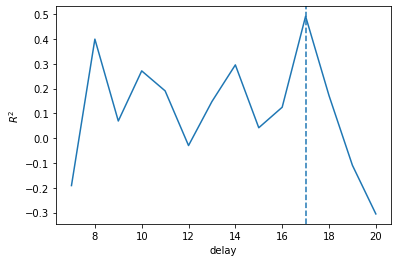

In [ ]:
plt.plot(grid, cv_arr)
plt.axvline(grid[cv_arr.argmax()], ls='--')
plt.xlabel('delay')
plt.ylabel('$R^2$')
plt.show()

In [ ]:
def linear_model(region, t0=None, delay=12, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - t0 (str) : beginning of time frame.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from(region, t0, None, delay, beta)
  X, y = preprocess(X_raw, y_raw)
  coef_names = X.columns.values

  lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**4)
  reg = lasso.fit(X, y)
  score = reg.score(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y

In [ ]:
# cv_arr = []
# grid = {'tr': [0.25, 0.5, 1, 2, 5], 'delay': [9, 12, 15, 18, 21]}
# lin = LinearRegression()
# for par in list(ParameterGrid(grid)):
#   cv_par = [linear_model(k, None, par['tr'], par['delay'])[3] for k in cc_dict.keys()]
#   cv_arr.append(cv_par)
# cv_arr = np.asarray(cv_arr).mean(axis=1) # country axis
# cv_arr

Performance ($R^2$) for the chosen parameteres. Is computed from the training data.

In [ ]:
models = [linear_model(k) for k in cc_dict.keys()]
r_sq = [reg.score(X, y) for reg, X, y in models]
np.asarray(r_sq).mean()

0.5111436893504098

In [ ]:
for r_i in r_sq:
  print(round(r_i, 2))

0.97
0.58
0.51
0.89
0.63
0.1
0.06
0.83
0.5
0.53
0.04
0.67
0.55
0.22
0.57


Same summary representation as for the previous model.

In [ ]:
idx = 8 # country index
cci = list(cc_dict.keys())[idx]
linear_model(cci, print=True)

Coefficients
------------
C3 : -0.000724
C4 : -0.043422
C5 : 0.003764
H6 : 0.020330
last : 0.462569

R^2
---
0.482


Resulting predictions of the model.

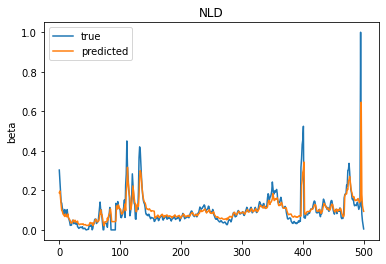

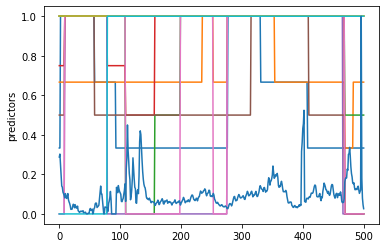


Number of data points: 501
Number of variables: 11


In [ ]:
model, X, y = linear_model(cci)

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('beta')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()

print('\nNumber of data points:', X.shape[0])
print('Number of variables:', X.shape[1])

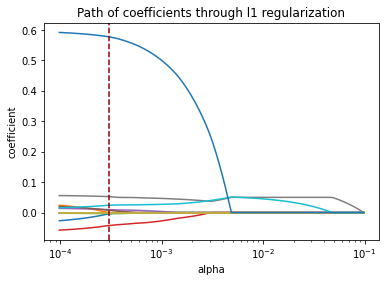

In [ ]:
alphas, coefs = model.path(X, y)[:2]
for coef in coefs:
  plt.semilogx(alphas, coef)
plt.axvline(model.alpha_, ls='--', color='darkred')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.title('Path of coefficients through l1 regularization')
plt.show()

The estimated transmission coefficient for every country of interest.

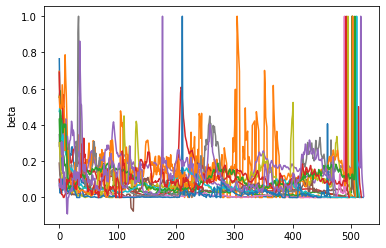

In [ ]:
for cc in cc_dict:
  model, X, y = linear_model(cc)
  plt.plot(y)
plt.ylabel('beta')
plt.show()

## Trials

Efficiency of applying weights to policy indicators in accordance to the proportion of the population who is affected by the policies.

In [ ]:
tot_dict = {
    code: name for code, name in zip(
        oxcgrt_sub['CountryCode'].unique(), 
        oxcgrt_sub['CountryName'].unique()
    )
}
tot_dict['USA'] = 'US'
tot_dict

{'BRA': 'Brazil',
 'CAN': 'Canada',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'USA': 'US'}

In [ ]:
sub_dict = {rc: rc.split('_')[0] for rc in oxcgrt_sub['RegionCode'].unique()}
for key in sub_dict.keys():
  # correct country codes
  sub_dict[key] = sub_dict[key].replace('BR', 'BRA')
  sub_dict[key] = sub_dict[key].replace('UK', 'GBR')
  sub_dict[key] = sub_dict[key].replace('US', 'USA')
sub_dict

{'BR_AC': 'BRA',
 'BR_AL': 'BRA',
 'BR_AM': 'BRA',
 'BR_AP': 'BRA',
 'BR_BA': 'BRA',
 'BR_CE': 'BRA',
 'BR_DF': 'BRA',
 'BR_ES': 'BRA',
 'BR_GO': 'BRA',
 'BR_MA': 'BRA',
 'BR_MG': 'BRA',
 'BR_MS': 'BRA',
 'BR_MT': 'BRA',
 'BR_PA': 'BRA',
 'BR_PB': 'BRA',
 'BR_PE': 'BRA',
 'BR_PI': 'BRA',
 'BR_PR': 'BRA',
 'BR_RJ': 'BRA',
 'BR_RN': 'BRA',
 'BR_RO': 'BRA',
 'BR_RR': 'BRA',
 'BR_RS': 'BRA',
 'BR_SC': 'BRA',
 'BR_SE': 'BRA',
 'BR_SP': 'BRA',
 'BR_TO': 'BRA',
 'CAN_AB': 'CAN',
 'CAN_BC': 'CAN',
 'CAN_MB': 'CAN',
 'CAN_NB': 'CAN',
 'CAN_NL': 'CAN',
 'CAN_NS': 'CAN',
 'CAN_NT': 'CAN',
 'CAN_NU': 'CAN',
 'CAN_ON': 'CAN',
 'CAN_PE': 'CAN',
 'CAN_QC': 'CAN',
 'CAN_SK': 'CAN',
 'CAN_YT': 'CAN',
 'CHN_AH': 'CHN',
 'CHN_BJ': 'CHN',
 'CHN_CQ': 'CHN',
 'CHN_FJ': 'CHN',
 'CHN_GD': 'CHN',
 'CHN_GS': 'CHN',
 'CHN_GX': 'CHN',
 'CHN_GZ': 'CHN',
 'CHN_HA': 'CHN',
 'CHN_HB': 'CHN',
 'CHN_HE': 'CHN',
 'CHN_HI': 'CHN',
 'CHN_HL': 'CHN',
 'CHN_HN': 'CHN',
 'CHN_JL': 'CHN',
 'CHN_JS': 'CHN',
 'CHN_JX': 'CHN',
 

In [ ]:
for code, name in zip(oxcgrt_sub['RegionCode'].unique(), oxcgrt_sub['RegionName'].unique()):
  print(code, '<->', name)

BR_AC <-> Acre
BR_AL <-> Alagoas
BR_AM <-> Amazonas
BR_AP <-> Amapa
BR_BA <-> Bahia
BR_CE <-> Ceara
BR_DF <-> Distrito Federal
BR_ES <-> Espirito Santo
BR_GO <-> Goias
BR_MA <-> Maranhao
BR_MG <-> Minas Gerais
BR_MS <-> Mato Grosso do Sul
BR_MT <-> Mato Grosso
BR_PA <-> Para
BR_PB <-> Paraiba
BR_PE <-> Pernambuco
BR_PI <-> Piaui
BR_PR <-> Parana
BR_RJ <-> Rio de Janeiro
BR_RN <-> Rio Grande do Norte
BR_RO <-> Rondonia
BR_RR <-> Roraima
BR_RS <-> Rio Grande do Sul
BR_SC <-> Santa Catarina
BR_SE <-> Sergipe
BR_SP <-> Sao Paulo
BR_TO <-> Tocantins
CAN_AB <-> Alberta
CAN_BC <-> British Columbia
CAN_MB <-> Manitoba
CAN_NB <-> New Brunswick
CAN_NL <-> Newfoundland and Labrador
CAN_NS <-> Nova Scotia
CAN_NT <-> Northwest Territories
CAN_NU <-> Nunavut
CAN_ON <-> Ontario
CAN_PE <-> Prince Edward Island
CAN_QC <-> Quebec
CAN_SK <-> Saskatchewan
CAN_YT <-> Yukon
CHN_AH <-> Anhui
CHN_BJ <-> Beijing
CHN_CQ <-> Chongqing
CHN_FJ <-> Fujian
CHN_GD <-> Guangdong
CHN_GS <-> Gansu
CHN_GX <-> Guangxi
CHN

In [ ]:
# https://worldpopulationreview.com/countries
tot_pop = {
    'BRA': 212559417,
    'CAN': 37742154,
    'CHN': 1439323776,
    'GBR': 67886011,
    'USA': 331002651
}

# https://en.wikipedia.org/wiki/List_of_Brazilian_states_by_population
# https://worldpopulationreview.com/canadian-provinces
# https://en.wikipedia.org/wiki/List_of_Chinese_administrative_divisions_by_population
# https://en.wikipedia.org/wiki/Countries_of_the_United_Kingdom_by_population (2019)
# https://worldpopulationreview.com/states (2021)
sub_pop = {
    'BR_AC': 894470, 'BR_AL': 3351543, 'BR_AM': 4207714,
    'BR_AP': 861773, 'BR_BA': 14930634, 'BR_CE': 9187103,
    'BR_DF': 3055149, 'BR_ES': 4064052, 'BR_GO': 7113540,
    'BR_MA': 7114598, 'BR_MG': 21292666, 'BR_MS': 2809394,
    'BR_MT': 3526220, 'BR_PA': 8690745, 'BR_PB': 4039277,
    'BR_PE': 9616621, 'BR_PI': 3281480, 'BR_PR': 11516840,
    'BR_RJ': 17366189, 'BR_RN': 3534165, 'BR_RO': 1796460,
    'BR_RR': 631181, 'BR_RS': 11422973, 'BR_SC': 7252502,
    'BR_SE': 2318822, 'BR_SP': 46289333, 'BR_TO': 1590248,
    'CAN_AB': 4428112, 'CAN_BC': 5145851, 'CAN_MB': 1379584,
    'CAN_NB': 781315, 'CAN_NL': 520998, 'CAN_NS': 979115,
    'CAN_NT': 45074, 'CAN_NU': 39285, 'CAN_ON': 14733119,
    'CAN_PE': 159713, 'CAN_QC': 8575779, 'CAN_SK': 1177884,
    'CAN_YT': 42176, 'CHN_AH': 61027171, 'CHN_BJ': 21893095,
    'CHN_CQ': 32054159, 'CHN_FJ': 41540086, 'CHN_GD': 126012510,
    'CHN_GS': 25019831, 'CHN_GX': 50126804, 'CHN_GZ': 38562148,
    'CHN_HA': 99365519, 'CHN_HB': 57752557, 'CHN_HE': 74610235,
    'CHN_HI': 10081232, 'CHN_HL': 31850088, 'CHN_HN': 66444864,
    'CHN_JL': 24073453, 'CHN_JS': 84748016, 'CHN_JX': 45188635,
    'CHN_LN': 42591407, 'CHN_NM': 24049155, 'CHN_NX': 7202654,
    'CHN_QH': 5923957, 'CHN_SC': 83674866, 'CHN_SD': 101527453,
    'CHN_SH': 24870895, 'CHN_SN': 39528999, 'CHN_SX': 34915616,
    'CHN_TJ': 13866009, 'CHN_XJ': 25852345, 'CHN_XZ': 3648100,
    'CHN_YN': 47209277, 'CHN_ZJ': 64567588, 'UK_ENG': 56286961,
    'UK_NIR': 1893667, 'UK_SCO': 5463300, 'UK_WAL': 3152879	,
    'US_AK': 724357, 'US_AL': 4934193, 'US_AR': 3033946,
    'US_AZ': 7520103, 'US_CA': 39613493, 'US_CO': 5893634,
    'US_CT': 3552821, 'US_DC': 714153, 'US_DE': 990334,
    'US_FL': 21944577, 'US_GA': 10830007, 'US_HI': 1406430,
    'US_IA': 3167974, 'US_ID': 1860123, 'US_IL': 12569321,
    'US_IN': 6805663, 'US_KS': 2917224, 'US_KY': 4480713,
    'US_LA': 4627002, 'US_MA': 6912239, 'US_MD': 6065436,
    'US_ME': 1354522, 'US_MI': 9992427, 'US_MN': 5706398,
    'US_MO': 6169038, 'US_MS': 2966407, 'US_MT': 1085004,
    'US_NC': 10701022, 'US_ND': 770026, 'US_NE': 1951996,
    'US_NH': 1372203, 'US_NJ': 8874520, 'US_NM': 2105005,
    'US_NV': 3185786, 'US_NY': 19299981, 'US_OH': 11714618,
    'US_OK': 3990443, 'US_OR': 4289439, 'US_PA': 12804123,
    'US_RI': 1061509, 'US_SC': 5277830, 'US_SD': 896581,
    'US_TN': 6944260, 'US_TX': 29730311, 'US_UT': 3310774,
    'US_VA': 8603985, 'US_VT': 623251, 'US_WA': 7796941,
    'US_WI': 5852490, 'US_WV': 1767859, 'US_WY': 581075
}

In [ ]:
sub_prop = {rc: sub_pop[rc] / tot_pop[cc] for rc, cc in sub_dict.items()}
sub_prop

{'BR_AC': 0.004208093965556934,
 'BR_AL': 0.015767558301121986,
 'BR_AM': 0.01979547205852564,
 'BR_AP': 0.004054268741243302,
 'BR_BA': 0.07024216668791484,
 'BR_CE': 0.043221340788679334,
 'BR_DF': 0.014373152895879461,
 'BR_ES': 0.019119604566849184,
 'BR_GO': 0.0334661249094412,
 'BR_MA': 0.03347110234123384,
 'BR_MG': 0.10017277192663734,
 'BR_MS': 0.013216982054481265,
 'BR_MT': 0.016589337935566505,
 'BR_PA': 0.04088619136549476,
 'BR_PB': 0.01900304892161047,
 'BR_PE': 0.04524203695948225,
 'BR_PI': 0.01543794222958374,
 'BR_PR': 0.05418174439196923,
 'BR_RJ': 0.08170039815267277,
 'BR_RN': 0.016626715719680395,
 'BR_RO': 0.008451566274290261,
 'BR_RR': 0.002969433247928037,
 'BR_RS': 0.053740140809663585,
 'BR_SC': 0.034119880936632416,
 'BR_SE': 0.010909053255448099,
 'BR_SP': 0.21777126439897979,
 'BR_TO': 0.007481428122283569,
 'CAN_AB': 0.1173253651606636,
 'CAN_BC': 0.13634227129696944,
 'CAN_MB': 0.036552868710143044,
 'CAN_NB': 0.020701388691276072,
 'CAN_NL': 0.0138041

In [ ]:
# REPEAT COMPUTATION OF LABELS
cum_cases_alt = jhu_cases[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_deaths_alt = jhu_death[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_recoveries_alt = jhu_recov[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()

R_alt = cum_deaths_alt + cum_recoveries_alt
I_alt = cum_cases_alt - R_alt
S_alt = tot_pop.values() - cum_cases_alt

i_prop_alt = I_alt / tot_pop.values()
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i_alt = np.log(i_prop_alt)
warnings.resetwarnings()
log_i_alt[np.isinf(log_i_alt)] = 0 # before the pandemic begins, the growth must be zero
gr_alt = log_i_alt[1:] - log_i_alt[:-1].values # different index
gr_alt

Country/Region,Brazil,Canada,China,United Kingdom,US
2020-01-23,0.000000,0.000000,0.229565,0.000000,0.117783
2020-01-24,0.000000,-19.055726,0.247127,0.000000,0.382992
2020-01-25,0.000000,0.693147,0.354482,0.000000,0.310155
2020-01-26,0.000000,0.693147,0.485826,0.000000,0.236389
2020-01-27,0.000000,0.405465,0.342863,0.000000,0.191055
...,...,...,...,...,...
2021-08-04,0.523196,0.678754,0.663966,0.411144,0.003972
2021-08-05,0.342168,0.400726,0.395651,0.302304,0.003477
2021-08-06,0.254244,0.285224,0.282832,0.244617,0.002997
2021-08-07,0.201703,0.221435,0.219786,0.195746,0.001872


Steps to apply the weights;
1. Pivot the original df and construct multilevel columns with region and country.
2. Convert to boolean type to obtain a binary representation.
3. Multiply by the proportional population
4. Stack the region column and group by date, which is equivalent to sum up the proportion of each region.

In [ ]:
C1_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[0])
C2_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[1])
C3_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[2])
C4_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[3])
C5_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[4])
C6_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[5])
C7_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[6])
C8_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[7])
H1_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[8])
H6_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[9])

C1_bin = C1_sub.astype(bool) * sub_prop.values()
C2_bin = C2_sub.astype(bool) * sub_prop.values()
C3_bin = C3_sub.astype(bool) * sub_prop.values()
C4_bin = C4_sub.astype(bool) * sub_prop.values()
C5_bin = C5_sub.astype(bool) * sub_prop.values()
C6_bin = C6_sub.astype(bool) * sub_prop.values()
C7_bin = C7_sub.astype(bool) * sub_prop.values()
C8_bin = C8_sub.astype(bool) * sub_prop.values()
H1_bin = H1_sub.astype(bool) * sub_prop.values()
H6_bin = H6_sub.astype(bool) * sub_prop.values()

C1_weights = C1_bin.stack().groupby('Date').sum()
C2_weights = C2_bin.stack().groupby('Date').sum()
C3_weights = C3_bin.stack().groupby('Date').sum()
C4_weights = C4_bin.stack().groupby('Date').sum()
C5_weights = C5_bin.stack().groupby('Date').sum()
C6_weights = C6_bin.stack().groupby('Date').sum()
C7_weights = C7_bin.stack().groupby('Date').sum()
C8_weights = C8_bin.stack().groupby('Date').sum()
H1_weights = H1_bin.stack().groupby('Date').sum()
H6_weights = H6_bin.stack().groupby('Date').sum()

CH_w = [
        C1_weights, C2_weights, C3_weights, C4_weights, C5_weights,
        C6_weights, C7_weights, C8_weights, H1_weights, H6_weights
]

Comparison between the fits with and without applying weights.

In [ ]:
def data_from_alt(iso, t0, tr, t_d, y, weight):
  'Select data with location and time constraints.'

  if iso in tot_dict.keys():
    name = tot_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  if not t0:
    t0 = cum_cases_alt.loc[cum_cases_alt[name] > 25, name].index.min()
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  prop_case = cum_cases_alt[name] / tot_pop[iso]
  t1 = prop_case[prop_case < tr/100].index.max()
  
  delay = pd.to_timedelta(t_d, unit='days')
  ch_x = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_X]
  pol_t = pd.concat(ch_x, axis=1, ignore_index=True)
  if weight:
    # apply policy weights
    ch_w = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_w]
    w_t = pd.concat(ch_w, axis=1, ignore_index=True)
    pol_t *= w_t
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

In [ ]:
def initial_model_weighted(region, tr=1, delay=12, weighted=True, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - weighted (bool) : wheter to apply weights to the policies.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from_alt(region, None, tr, delay, gr_alt, weighted)
  X, y = preprocess(X_raw, y_raw) 
  coef_names = X.columns.values

  lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**4)
  reg = lasso.fit(X, y)
  score = reg.score(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y

Don't apply weights

In [ ]:
models = [initial_model_weighted(k, weighted=False) for k in tot_dict.keys()]
r_sq = [reg.score(X, y) for reg, X, y in models]
np.asarray(r_sq).mean()

0.6821626619716219

In [ ]:
idx = 1 # country index
cci = list(tot_dict.keys())[idx]
initial_model_weighted(cci, weighted=False, print=True)

Coefficients
------------
C1 : -0.040706
C4 : -0.036710
C7 : -0.078763
last : 0.373677

R^2
---
0.681


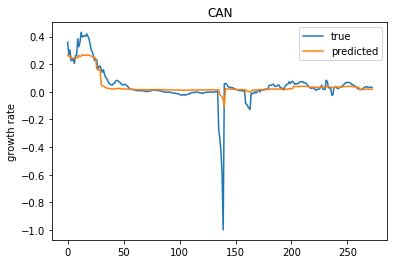

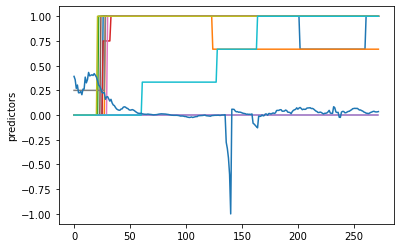

In [ ]:
model, X, y = initial_model_weighted(cci, weighted=False)

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()

Apply weights

In [ ]:
models = [initial_model_weighted(k, weighted=True) for k in tot_dict.keys()]
r_sq = [reg.score(X, y) for reg, X, y in models]
np.asarray(r_sq).mean()

0.6796562942895068

In [ ]:
cci = list(tot_dict.keys())[idx]
initial_model_weighted(cci, print=True)

Coefficients
------------
C1 : -0.033003
C4 : -0.122328
last : 0.375121

R^2
---
0.679


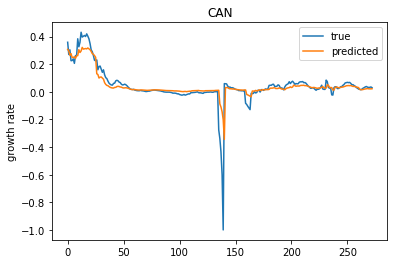

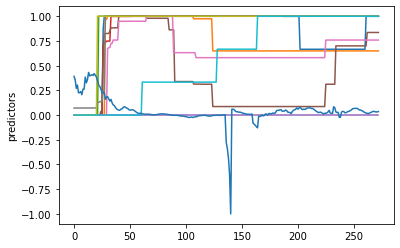

In [ ]:
model, X, y = initial_model_weighted(cci)

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()